# Importation des librairies

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
import pandas
import numpy as np
import ipywidgets 
from IPython.display import display
from ipywidgets import interact, Layout
%matplotlib notebook 

In [30]:
import sys, os
workDir = f"{os.getcwd()}/.."
libDir = f"{workDir}/lib"
dataDir= f"{workDir}/data" 

sys.path.append(libDir)

## Lecture du fichier mitab

In [31]:
file_prot = open("../proteins.mitab")
list_prot=[]

# Récupération de tuples correspondant à une intéraction entre deux protéines, associées à une couleurs 
# (dissociant physique et non physique)

for line in file_prot.readlines(): 
    x = line.split('\t')
    if x[1].split(':')[1][0] == 'P' or x[1].split(':')[1][0] == 'Q':
        if "physical" in x[11]:
            list_prot.append((x[0].split(':')[1], x[1].split(':')[1], '#B73E3E'))
        else:
            list_prot.append((x[0].split(':')[1], x[1].split(':')[1], '#4C6793'))

file_prot.close()

## Récupération des données TCL_wt1

In [32]:
TCL_wt1 = pandas.read_csv(f"{workDir}/TCL_wt1.tsv", sep="\t",
                          na_values='#VALEUR!',
    dtype = {
       "Log2 Corrected Abundance Ratio" : np.float64,
       "LOG10 Adj.P-val" : np.float64
    }).dropna()

In [33]:
abundance     = TCL_wt1["Log2 Corrected Abundance Ratio"].tolist()
pvalues       = TCL_wt1["LOG10 Adj.P-val"].tolist()
uniprot_ids   = TCL_wt1["Accession"].tolist()

dict_sa = dict(zip(uniprot_ids, abundance))

## Récupération des termes GO

In [34]:
import json
go_ora_data = []
with open(f"{dataDir}/ora/biological_process_ora.json", 'r') as fp:
    go_ora_data = json.load(fp)

In [35]:
go_ora_dict = { go[1] : {
    'pvalue'   : go[0],
    'proteins' : go[3],
    'id'       : go[2]
} for go in go_ora_data }
go_ora_dict

{'ion transport': {'pvalue': 1.5986964238457479e-06,
  'proteins': ['P0A927',
   'P0A910',
   'P06996',
   'P76506',
   'P02930',
   'P13036',
   'P13036',
   'P06971',
   'P75780',
   'P0A910',
   'P06129',
   'P02930',
   'P02931'],
  'id': 'GO:0006811'},
 'siderophore transport': {'pvalue': 1.7151956236568863e-06,
  'proteins': ['P13036', 'P06971', 'P75780', 'P02930'],
  'id': 'GO:0015891'},
 'iron ion transport': {'pvalue': 3.9656167187060204e-05,
  'proteins': ['P13036', 'P13036', 'P06971', 'P75780', 'P02930'],
  'id': 'GO:0006826'},
 'phospholipid transport': {'pvalue': 0.0003065241538170312,
  'proteins': ['P06996', 'P76506'],
  'id': 'GO:0015914'},
 'transport': {'pvalue': 0.000548579030879118,
  'proteins': ['P06996',
   'P76506',
   'P02930',
   'P0A927',
   'P75780',
   'P06129',
   'P0A927',
   'P0A910',
   'P13036',
   'P13036',
   'P06971',
   'P75780',
   'P0A910',
   'P06129',
   'P02930',
   'P02931',
   'P02931',
   'P02930'],
  'id': 'GO:0006810'},
 'iron ion homeost

## Préparation pour le network graph
### Déclaration de variables

In [36]:
labels = uniprot_ids

G = nx.Graph()
dict_inter = {}
dict_edge = {}

list_edges = []
list_color = []
list_color_node = []

pathway_labels = list(go_ora_dict.keys())
nodes = np.array(G.nodes)

### Création des arêtes

In [37]:
for prots in list_prot:
    prots1 = prots[0]
    prots2 = prots[1]
    colors = prots[2]
    
    (prots1, prots2) = (prots1, prots2) if prots1 > prots2 else (prots2, prots1)
    
    if (prots1 in uniprot_ids) and (prots2 in uniprot_ids):
        if not G.has_edge(prots1, prots2):
            G.add_edge(prots1, prots2, count = 1, color = colors)
        G[prots1][prots2]['count'] += 1

        if prots1 in dict_inter:
            if prots2 not in dict_inter[prots1]:
                dict_inter[prots1].append(prots2)
        else:
            dict_inter[prots1]=[prots2]
        if prots2 in dict_inter:
            if prots1 not in dict_inter[prots2]:
                dict_inter[prots2].append(prots1)
        else:
            dict_inter[prots2]=[prots1]

for prots in dict_inter:
    dict_inter[prots]=len(dict_inter[prots])



for edge in G.edges:
    list_edges.append(1 * G.get_edge_data(*edge)['count'])
    list_color.append(G.get_edge_data(*edge)['color'])

for node in G.nodes:
    if node in dict_sa:
        list_color_node.append(dict_sa[node])


nodes = [50 * s for s in dict_inter.values()]
pos = nx.spring_layout(G, k=0.2)
#nx.draw(G, pos, node_size= nodes, alpha = 0.7, width=list_edges, edge_color = list_color)

### Retire les termes GO non utilisés avec le jeu de données

In [38]:
list_to_pop = []
for go in go_ora_dict:
    for prot in go_ora_dict[go]['proteins']:

        if prot not in G.nodes:
            print(prot)
            go_ora_dict[go]['proteins'].remove(prot)

    if len(go_ora_dict[go]['proteins']) == 0:
        list_to_pop.append(go)

for go in list_to_pop:
    go_ora_dict.pop(go)

P0A927
P02930
P75780
P06129
P75780
P75780
P02930
P75780
P0A927
P75780
P06129
P02930
P75780
P02930
P75780
P0A927
P75780
P06129
P02930
P75780
P75780
P77330
P0A927
P75780
P06129
P06129
P0A927
P06129
P77330
P77330
P77330
P06129
P02930
P0A927
P02930
P0A927
P02930
P75780
P02930
P06129
P0A927
P02930
P75780
P02930
P0A927
P06129
P77330
P0AB40
P77330
P77330
P0AB40
P02930
P02930
P0A927
P06129
P0A927
P0A908
P0A908
P0A908
P0A908
P0A908
P0A908
P77330
P0A908
P0A908
P0A908
P0A908
P77330
P75780
P0A908
P02930
P0A908
P0A908
P0A908
P0A908
P0A908
P0A908
P0A908
P0A908
P0A908
P0A908
P0A908
P0A908
P77330
P0A908
P0A908
P0A908
P0A908
P02930
P75780
P0A927
P75780
P06129
P02930
P77330
P0A908
P75780
P0AB40
P02930


### Dictionnaire liant proteines à une liste de termes GO

In [39]:
dict_prot_to_go = {}

for go in go_ora_dict:
    for prot in G.nodes:
        if prot not in dict_prot_to_go:
            dict_prot_to_go[prot] = []
        #print(go_ora_dict[go]['proteins'])
        if prot in go_ora_dict[go]['proteins']:
            dict_prot_to_go[prot].append(go)

dict_prot_to_go

{'P0A6X3': [],
 'P02358': [],
 'P0AFG8': [],
 'P0ACF8': [],
 'P0A6Y1': [],
 'P62399': [],
 'P36659': [],
 'P30871': [],
 'P06996': ['ion transport',
  'phospholipid transport',
  'transport',
  'localization',
  'lipid transport',
  'organic substance transport',
  'organic anion transport',
  'response to stimulus',
  'cellular response to stimulus',
  'cellular response to stress',
  'cellular response to DNA damage stimulus',
  'response to stress',
  'cellular process',
  'biological_process'],
 'P0A8J8': [],
 'P37095': [],
 'P0A910': ['ion transport',
  'transport',
  'localization',
  'viral entry into host cell',
  'ion transmembrane transport',
  'detection of virus',
  'interaction with host',
  'symbiotic process',
  'conjugation',
  'interspecies interaction between organisms',
  'transmembrane transport',
  'response to virus',
  'response to stimulus',
  'response to other organism',
  'response to external biotic stimulus',
  'response to external stimulus',
  'multi-orga

## Définition des intéractions et Graphe

<IPython.core.display.Javascript object>


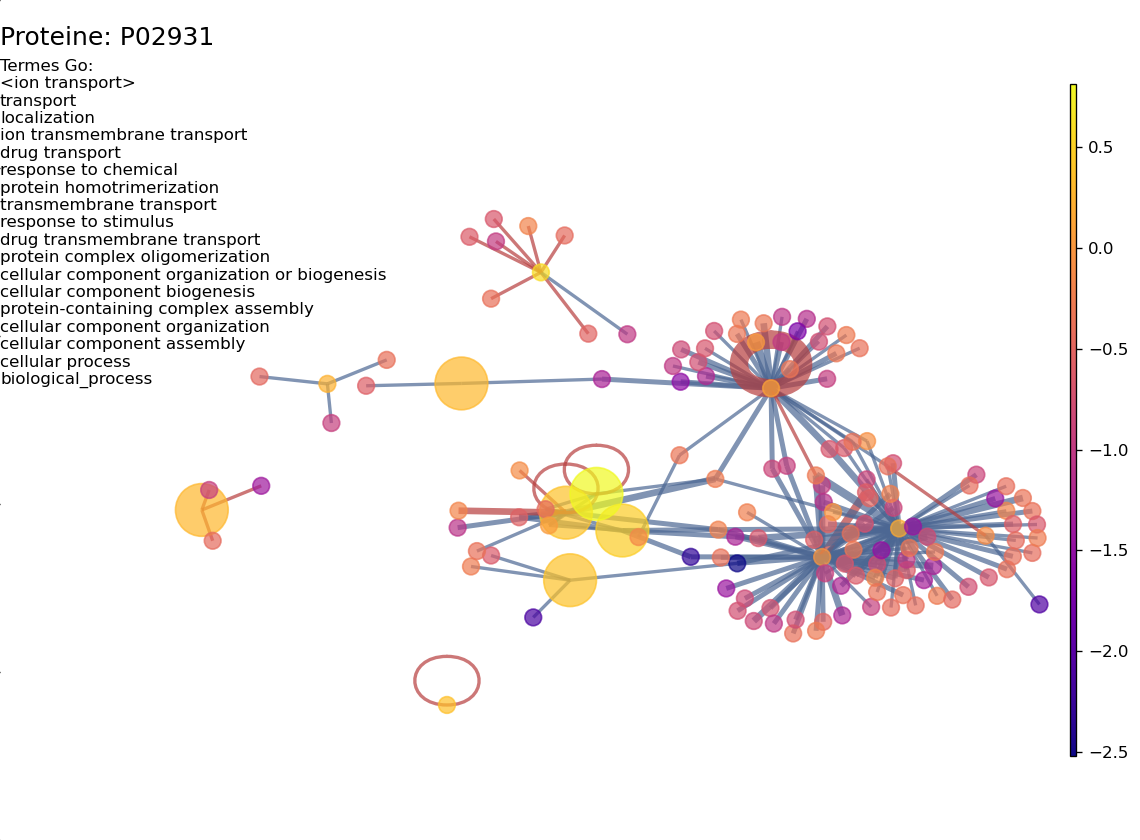

interactive(children=(Dropdown(description='Pathway:', layout=Layout(object_position='right'), options=('ion t…

In [40]:
pathway_labels = list(go_ora_dict.keys())
nodes = np.array(G.nodes)

def onpick(event):
    pathwaylabel = wid_dropdown.value
    ind = event.ind
    tx = str(ind).split("[")[1].split("]")[0]
    prot = nodes[int(tx)]
    protein_id.set_text(f"Proteine: {prot}")
    if len(dict_prot_to_go[prot]) == 0:
        go_list.set_text("Termes GO:\n None")
    else:
        str_go = "Termes Go:\n"
        for term in dict_prot_to_go[prot]:
            if pathwaylabel==term:
                str_go+="<"+term+">\n"
            else:
                str_go+=term+"\n"
        go_list.set_text(str_go)
    #ax_final.set_title(tx)
    #path_collection.set_sizes( np.random.rand(100) * 100 )

def getColor(uniprot_id, pathway_label):
    if uniprot_id in go_ora_dict[pathway_label]['proteins']:
        return 'tab:red'
    else:
        return 'tab:grey'

def getSize(uniprot_id, pathway_label, min_v = 100, max_v = 1000):
    if uniprot_id in go_ora_dict[pathway_label]['proteins']:
        return max_v
    else:
        return min_v


wid_dropdown = ipywidgets.Dropdown(
    options=pathway_labels,
    description='Pathway:',
    disabled=False,
    layout=Layout(object_position="right")
)

#fig_final, ax_final = plt.subplots(figsize=(9,6), ncols=1, nrows=1)
fig_final = plt.figure("GO : ion transport", figsize=(9.5,7))
ax_final = fig_final.add_axes([0.1, 0.1, 0.89, 0.7])
#fig_final.set_figheight(7)
#fig_final.set_figwidth(9.5)
ax_text = fig_final.add_axes([0, 0, 0.1, 1], frameon=False)
ax_color = fig_final.add_axes([0.94, 0.1, 0.005, 0.8])


# nx.draw(G, pos , ax_final, node_color= "black", node_size= 100, alpha = 0.7, width=list_edges, edge_color = list_color)


def updateDropdown(w):
    global protein_id, go_list
    pathway_label =  w
    newcolors, newsize = [], []
    for node in G.nodes:
        #newcolors.append(getColor(node, pathway_label))
        newsize.append(getSize(node, pathway_label))
    #plt.clf()
    ax_final.clear()
    nx.draw(G, pos, ax_final, node_color = list_color_node, cmap=plt.cm.plasma, node_size= newsize, alpha = 0.7, width=list_edges, edge_color = list_color)
    protein_id = ax_text.text(0,0.94, "Proteine:", va="bottom", ha="left", fontsize=15)
    go_list = ax_text.text(-0,0.93, "Terme GO:", va="top", ha="left")
    nw = ax_final.collections[0]
    nw.set_picker(True)
    
    cmap=plt.cm.plasma
    vmin = min(list_color_node)
    vmax = max(list_color_node)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    plt.colorbar(sm,ax_color)
    
    fig_final.canvas.manager.set_window_title(f"GO : {pathway_label}")


interact(updateDropdown,w=wid_dropdown)
cid = fig_final.canvas.mpl_connect('pick_event', onpick)